# Stanford CME 241 (Winter 2024) - Assignment 5

**Due: Feb 12 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Solve any 3 of the 4 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/HenriqueMonteiro35/RL-book/blob/master/assignment5.ipynb

*Group members (replace below names with people in your group):*
- Arantxa Ramos del Valle - aramosv
- Henrique Bittencourt Netto Monteiro - hbnm

## Imports

In [19]:
from typing import Callable, Sequence, Tuple, Iterator
from dataclasses import dataclass
import matplotlib.pyplot as plt
from numpy.random import poisson, randint, normal, uniform
import numpy as np

from rl.distribution import Distribution, Constant, SampledDistribution, Gaussian, Choose
from rl.markov_process import S, State, NonTerminal, MarkovProcess
from rl.markov_decision_process import MarkovDecisionProcess, NonTerminal, State
from rl.chapter9.order_book import DollarsAndShares, OrderBook
from rl.chapter9.optimal_order_execution import OptimalOrderExecution
from rl.function_approx import FunctionApprox, LinearFunctionApprox
from rl.policy import DeterministicPolicy
from rl.approximate_dynamic_programming import back_opt_vf_and_policy, ValueFunctionApprox


## Question 1
You are a milkvendor and your task is to bring to your store a supply
(denoted $S \in \mathbb{R}$) of milk volume in the morning that will
give you the best profits. You know that the demand for milk through the
course of the day is a probability distribution function $f$ (for
mathematical convenience, assume people can buy milk in volumes that are
real numbers, hence milk demand $x \in \mathbb{R}$ is a continuous
variable with a probability density function). For every extra gallon of
milk you carry at the end of the day (supply $S$ exceeds random demand
$x$), you incur a cost of $h$ (effectively the wasteful purchases
amounting to the difference between your purchase price and end-of-day
discount disposal price since you are not allowed to sell the same milk
the next day). For every gallon of milk that a customer demands that you
don't carry (random demand $x$ exceeds supply $S$), you incur a cost of
$p$ (effectively the missed sales revenue amounting to the difference
between your sales price and purchase price). So your task is to
identify the optimal supply $S$ that minimizes your Expected Cost
$g(S)$, given by the following:

$$g_1(S) = E[\max(x-S, 0)] = \int_{-\infty}^{\infty} \max(x-S, 0) \cdot f(x) \cdot dx = \int_S^{\infty} (x-S) \cdot f(x) \cdot dx$$
$$g_2(S) = E[\max(S-x, 0)] = \int_{-\infty}^{\infty} \max(S-x, 0) \cdot f(x) \cdot dx = \int_{-\infty}^S (S-x) \cdot f(x) \cdot dx$$

$$g(S) = p \cdot g_1(S) + h \cdot g_2(S)$$

After you solve this problem, see if you can frame this problem in terms
of a call/put options portfolio problem.

**ANSWER:** to minimize the cost, let's differentiate the expected cost $g(S)$ with respect to $S$ and equate to zero,

$$
\frac{\partial}{\partial S} g(S) = p \frac{\partial}{\partial S} \int_S^{\infty} (x-S) f(x) dx + h \frac{\partial}{\partial S} \int_{-\infty}^S (S-x) f(x) dx = 0
$$

$$
p \left( - (S-S) f(S) - \int_S^{\infty} f(x) dx \right)
+ h \left( (S-S) f(S) + \int_{-\infty}^S f(x) dx \right) = 0
$$

$$
p \int_S^{\infty} f(x) dx = h \int_{-\infty}^S f(x) dx
$$

Let $F(x)$ be the CDF of the distribution $f$. Then,

$$
p (1 - F(S)) = h F(S)
$$

$$
F(S) = \frac{p}{p + h}
$$

$$
S = F^{-1} \left( \frac{p}{p + h} \right)
$$

in which $F^{-1}$ is the inverse CDF of the distribution $f$.

**INTUITION**: the solution makes sense as we should buy more inventory the greater the cost $p$ of missed revenue and less inventory the greater the cost $h$ of unsold milk. Additionally, as $p/h \to \infty$, the CDF goes to 1, i.e.: we should buy as much supply as possible to never miss revenue, and for $p/h \to 0$, the CDF goes to 0, i.e.: we should buy the bare minimum to never have unsold inventory.

**OPTIONS REFRAMING**: if we interpret the decision variable $S$ as the strike of an option and $f(x)$ as the distribution of the price of the underlying at expiration $T$, then

- $g_1(S)$: payoff at expiration $T$ of a call option with strike $S$.
- $g_2(S)$: payoff at expiration $T$ of a put option with strike $S$.

Then $g(S) = p \cdot g_1(S) + h \cdot g_2(S)$ becomes the payoff at expiration $T$ of a portfolio with $p$ units of the call option and $h$ units of the put option.

If $f$ is the risk-free distribution used to price the option chain (Q measure), then findinding some $S$ to minimize $g(S)$ corresponds to the problem of finding the strike price which affords the cheapest portfolio of $p$ calls and $h$ puts with strike $S$, in case we want to long a portfolio of that kind.

If $f$ is instead an estimated distribution to predict future returns (P measure), then findinding some $S$ to minimize $g(S)$ corresponds to the problem of finding the strike with the portfolio of $p$ calls and $h$ puts with strike $S$ with the smallest expected value, in case we want to short/sell a portfolio of that kind.

## Question 2
[rl/chapter8/optimal_bin_tree.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter8/optimal_exercise_bin_tree.py)
models the American Payoff pricing problem as a `FiniteMarkovDecisionProcess` in the form of a binary tree with only two
discrete transitions for any given asset price. In the world of mathematical and computational finance, it is common practice to work
with continuous-valued asset prices and transitions to a continuous set of asset prices for the next time step. Your task is to model this
problem as a `MarkovDecisionProcess` (not finite) with discrete time, continuous-valued asset prices and a continuous-set of transitions.
Assume an arbitrary probability distribution for asset price movements from one time step to another, so you'd be sampling from the arbitrary
transition probability distribution. Hence, you will be solving this problem with Approximate Dynamic Programming using the code in
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py).

## Question 3
We'd like to build a simple simulator of Order Book Dynamics as a
`MarkovProcess` using the code in
[rl/chapter9/order_book.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter9/order_book.py).
An object of type `OrderBook` constitutes the *State*. Your task is to
come up with a simple model for random arrivals of Market Orders and
Limit Orders based on the current contents of the `OrderBook`. This
model of random arrivals of Marker Orders and Limit Orders defines the
probabilistic transitions from the current state (`OrderBook` object) to
the next state (`OrderBook` object). Implement the probabilistic
transitions as a `MarkovProcess` and use it's `simulate` method to
complete your implementation of a simple simulator of Order Book
Dynamics.

Experiment with different models for random arrivals of Market Orders
and Limit Orders.

In [2]:
@dataclass
class OrderBookMarkovProcess(MarkovProcess):
    f_order_size: Callable[[S], int]
    f_limit_price: Callable[[S], int]

    @staticmethod
    def plot(state: NonTerminal[OrderBook]):
        plt.rcParams["figure.figsize"] = [12, 4]
        state.state.display_order_book()

    def transition(self, state: NonTerminal[S]) -> Distribution[State[S]]:
        '''Given a state of the process, returns a distribution of
        the next states.  Returning None means we are in a terminal state.
        '''

        def sampler():
            order_type = "MARKET" if randint(0, 1+1) == 1 else "LIMIT"
            order_size = self.f_order_size(state.state)

            if order_type == "LIMIT":
                limit_price = self.f_limit_price(state.state)

                order_direction = "BUY" if limit_price < state.state.mid_price() else "SELL"
                if order_direction == "BUY":
                    _, new_lob = state.state.buy_limit_order(limit_price, order_size)
                else:
                    _, new_lob = state.state.sell_limit_order(limit_price, order_size)

                print(f"New trade: {order_direction} LIMIT order with price {limit_price} and size {order_size}.")

            # "MARKET"
            else:
                order_direction = "BUY" if randint(0, 1+1) == 1 else "SELL"
                if order_direction == "BUY":
                    _, new_lob = state.state.buy_market_order(order_size)
                else:
                    _, new_lob = state.state.sell_market_order(order_size)

                print(f"New trade: {order_direction} MARKET order with size {order_size}.")

            return NonTerminal(new_lob)

        return SampledDistribution(sampler=sampler)

In [3]:
def get_initial_lob():
    bids: PriceSizePairs = [DollarsAndShares(
        dollars=x,
        shares=poisson(25. + 10*(100 - x) + (100 - x)**2)
    ) for x in range(100, 90, -1)]

    asks: PriceSizePairs = [DollarsAndShares(
            dollars=x,
            shares=poisson(25. + 10*(x - 105) + (x - 105)**2)
        ) for x in range(105, 115, 1)]

    lob : OrderBook = OrderBook(descending_bids=bids, ascending_asks=asks)
    return lob

In [4]:
def run_LOB(f_order_size=None, f_limit_price=None, num_orders=10):
    initial_lob = get_initial_lob()
    initial_state = Constant(NonTerminal(initial_lob))
    obmp = OrderBookMarkovProcess(
        f_order_size=f_order_size,
        f_limit_price=f_limit_price
    )

    simulator = obmp.simulate(initial_state)
    for i in range(num_orders):
        state = simulator.__next__()
        obmp.plot(state)

### NOTE: all examples below contain BOTH market and limit orders to be realistic, and they vary in how the order sizes (for both market and limit orders) and how the order prices (only for limit orders) are distributed. They all simulate the arrival of 10 random orders.

## Example 1: large (mean = 50) Poisson order sizes and Gaussian limit prices

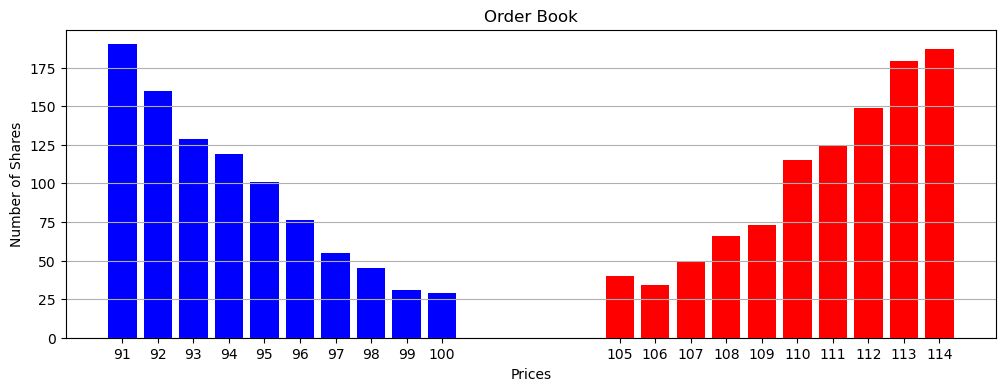

New trade: SELL LIMIT order with price 104 and size 54.


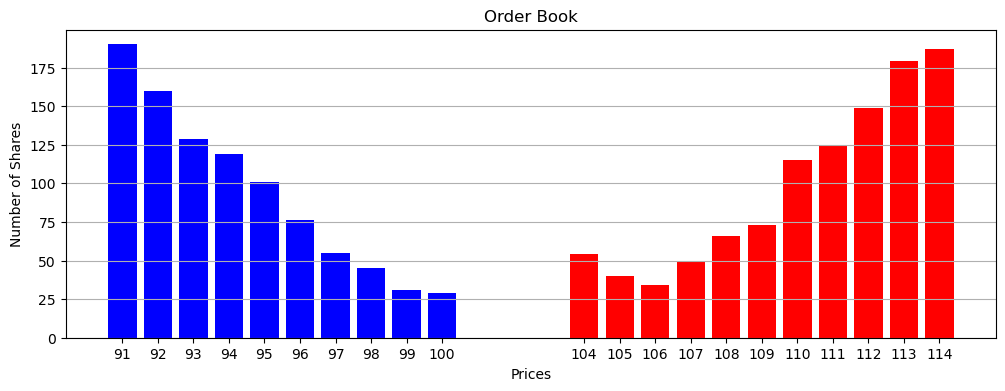

New trade: SELL LIMIT order with price 111 and size 47.


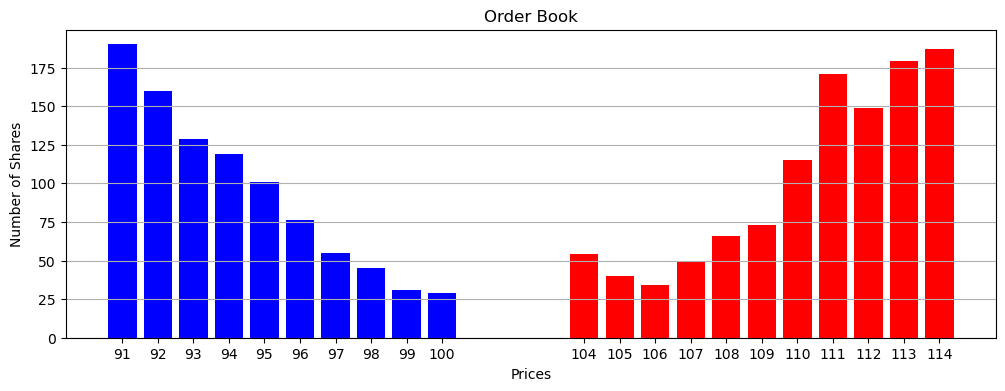

New trade: SELL LIMIT order with price 111 and size 34.


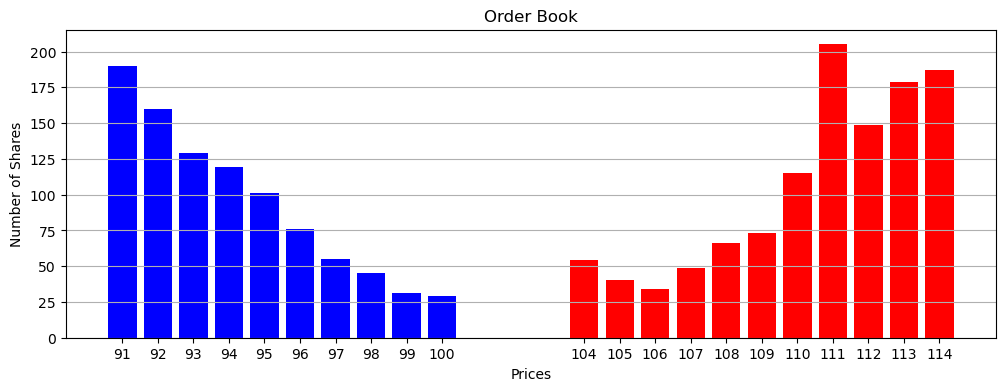

New trade: BUY LIMIT order with price 101 and size 36.


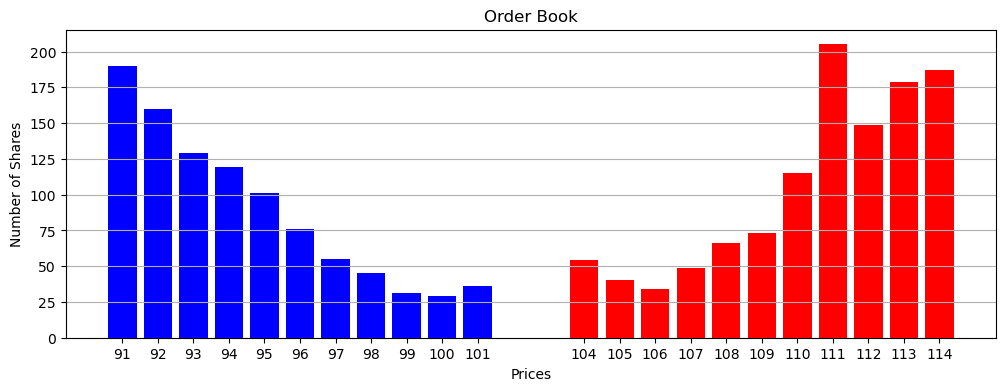

New trade: SELL LIMIT order with price 106 and size 46.


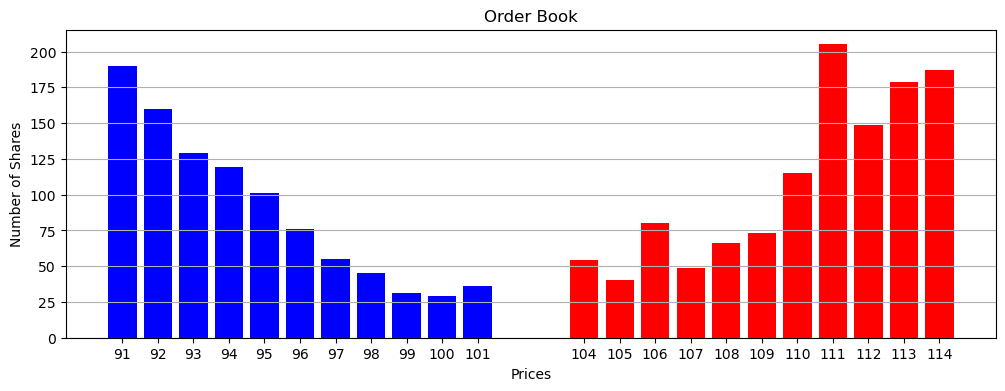

New trade: BUY MARKET order with size 41.


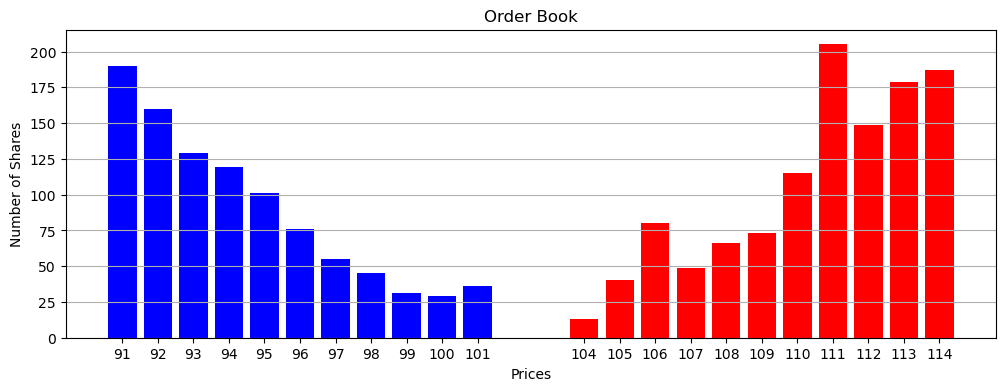

New trade: BUY LIMIT order with price 101 and size 49.


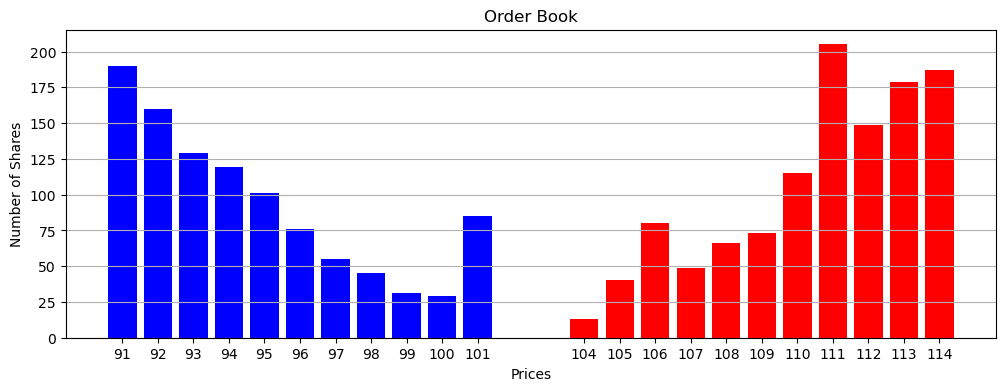

New trade: SELL LIMIT order with price 104 and size 49.


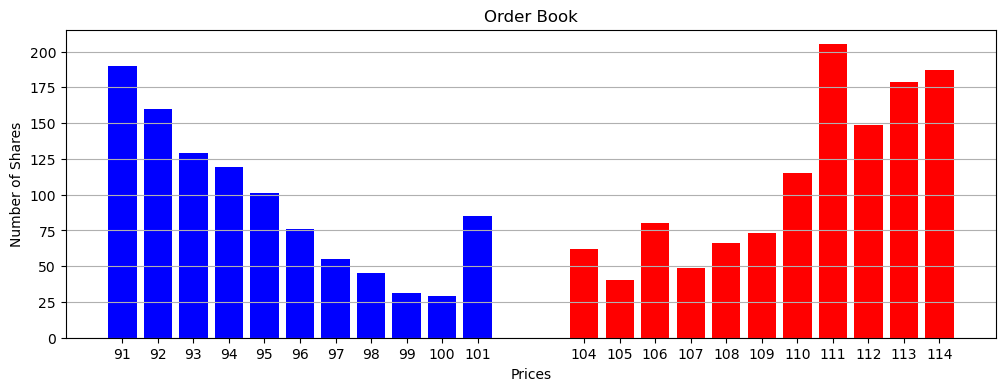

New trade: BUY MARKET order with size 58.


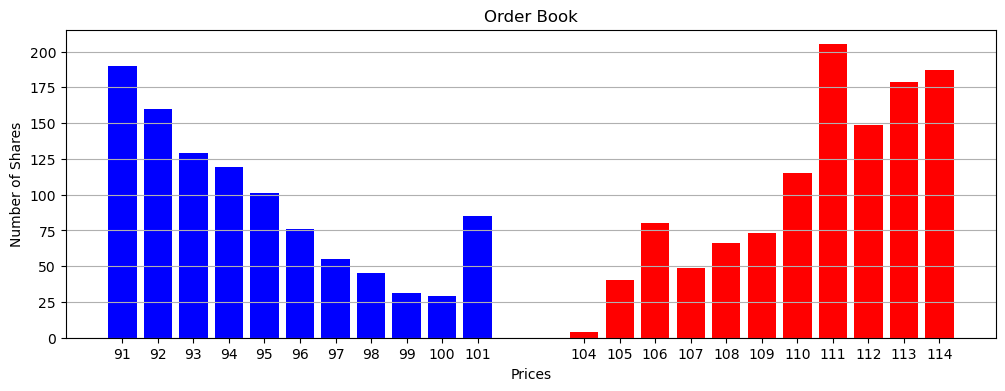

In [5]:
run_LOB(
    f_order_size = lambda lob: poisson(lam=50),
    f_limit_price = lambda lob: round(normal(lob.mid_price(), lob.market_depth()/4))
)

## Example 2: medium (mean = 30) Gaussian order sizes and Gaussian limit prices

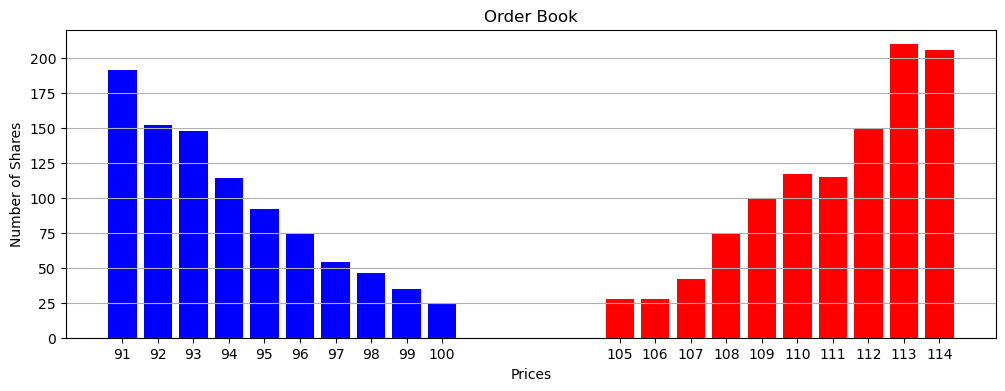

New trade: SELL LIMIT order with price 108 and size 16.


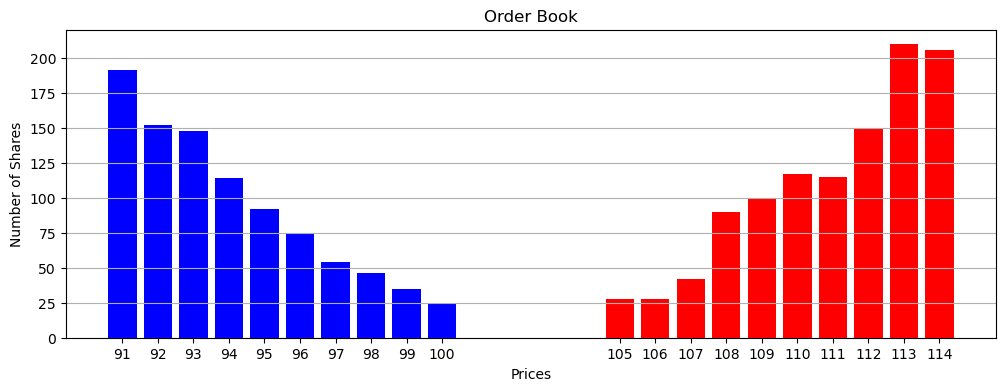

New trade: SELL LIMIT order with price 104 and size 28.


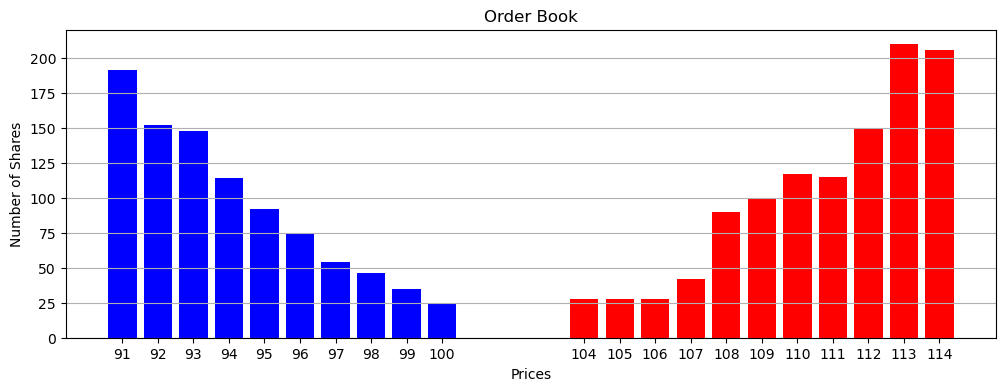

New trade: BUY MARKET order with size 23.


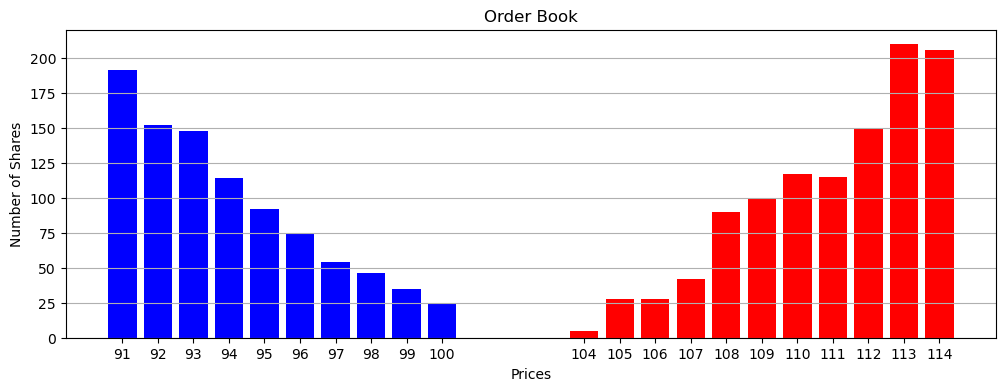

New trade: BUY MARKET order with size 13.


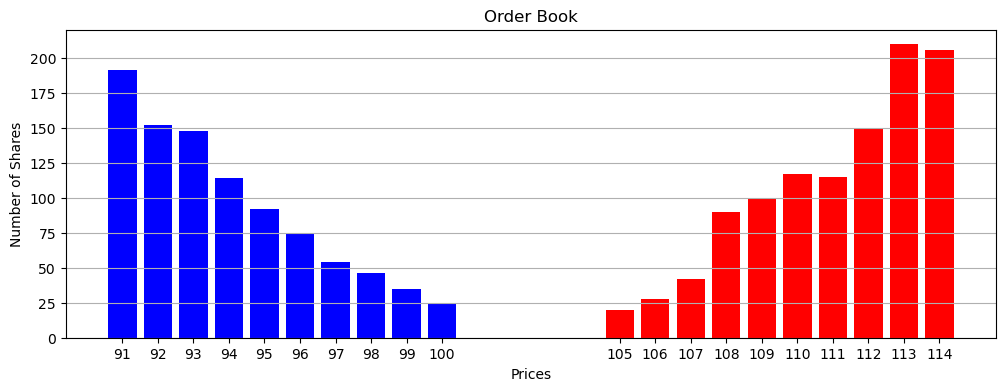

New trade: SELL MARKET order with size 33.


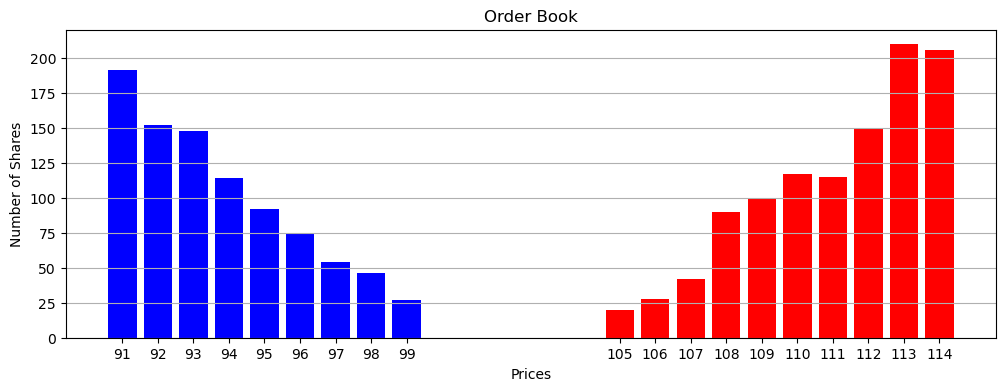

New trade: BUY MARKET order with size 27.


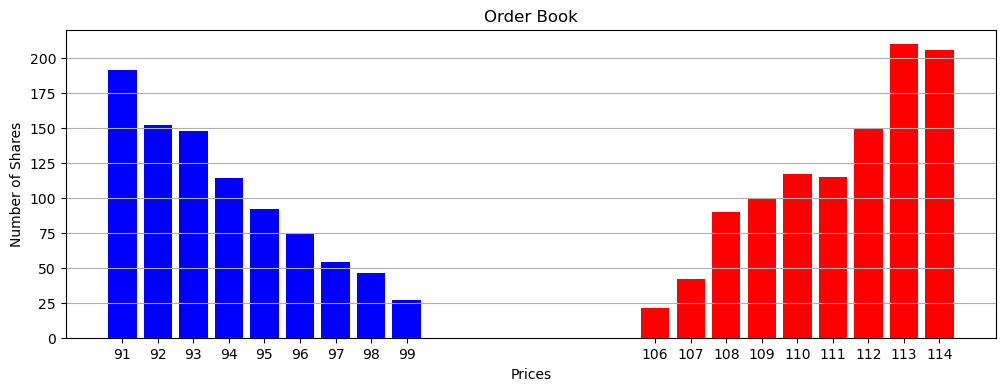

New trade: SELL LIMIT order with price 113 and size 24.


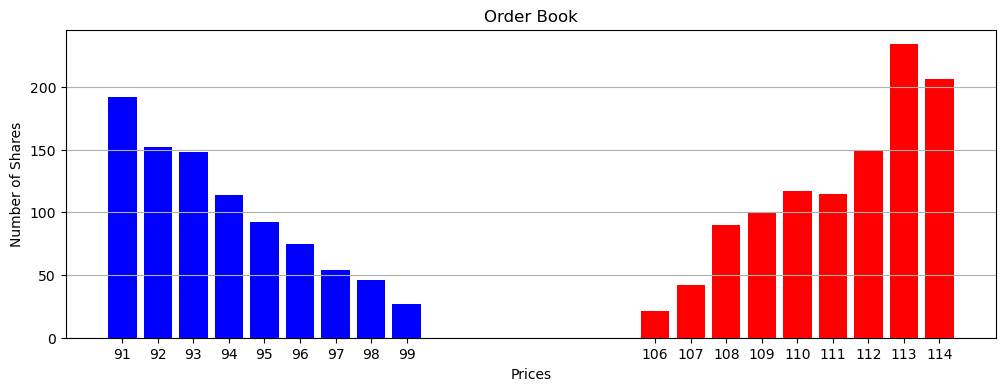

New trade: BUY MARKET order with size 18.


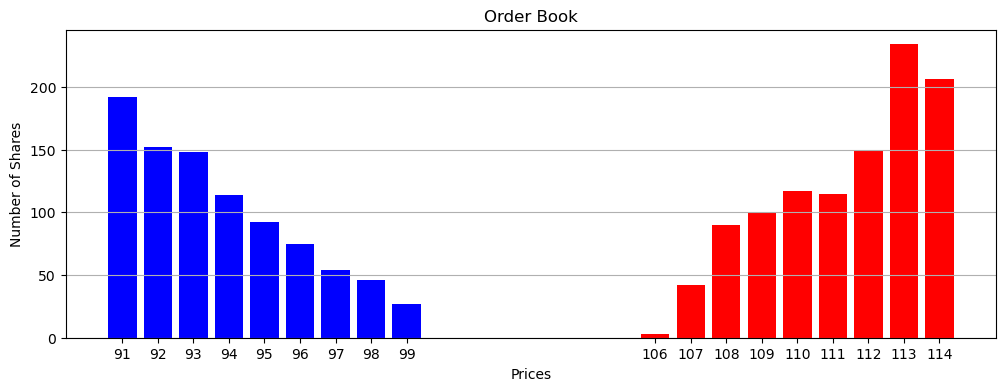

New trade: BUY LIMIT order with price 99 and size 33.


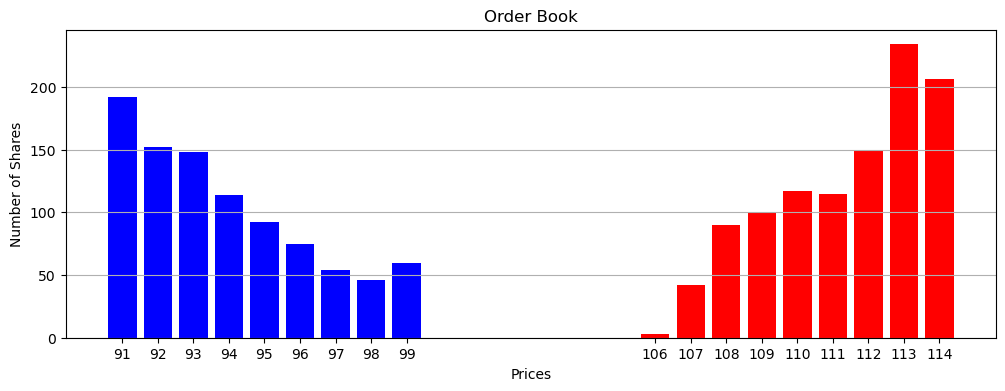

In [6]:
run_LOB(
    f_order_size = lambda lob: max(1, round(normal(30, 10))),
    f_limit_price = lambda lob: round(normal(lob.mid_price(), lob.market_depth()/5))
)

## Example 3: small (mean = 15) uniform order sizes and uniform limit prices

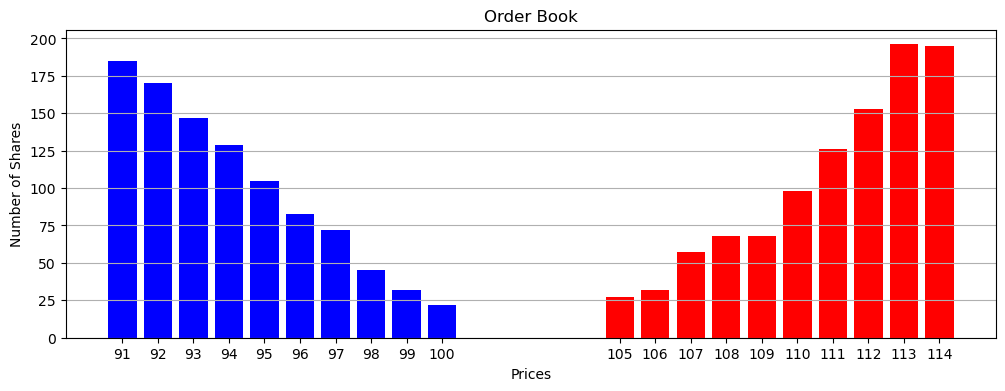

New trade: BUY LIMIT order with price 101 and size 19.


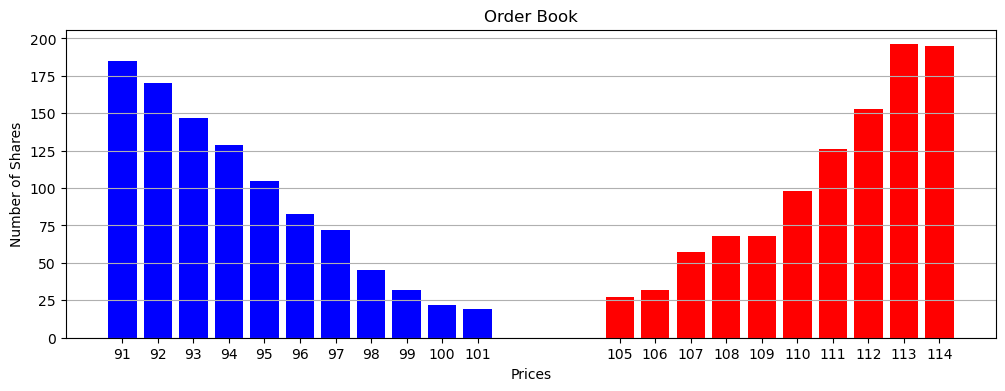

New trade: SELL MARKET order with size 12.


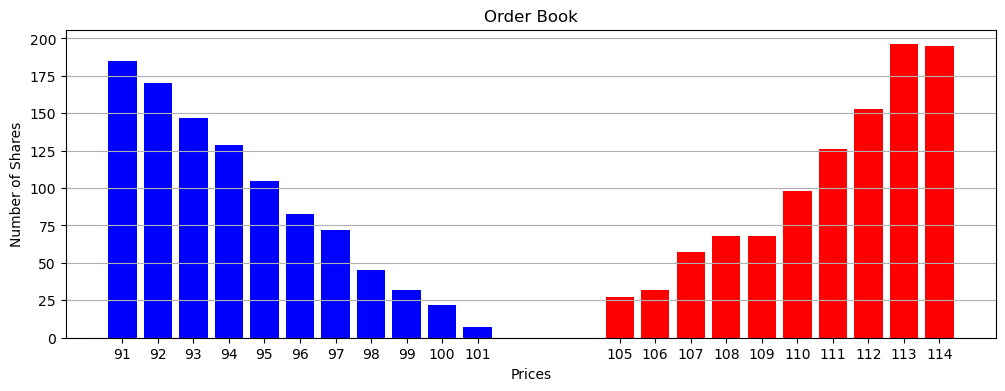

New trade: BUY LIMIT order with price 102 and size 14.


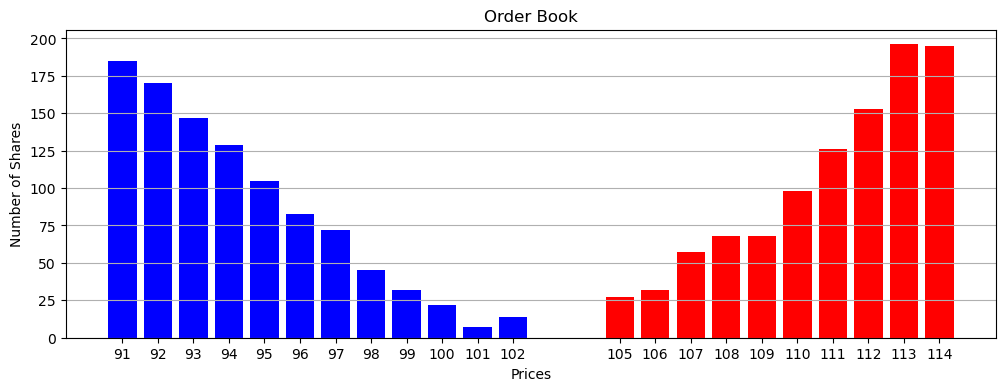

New trade: BUY LIMIT order with price 101 and size 17.


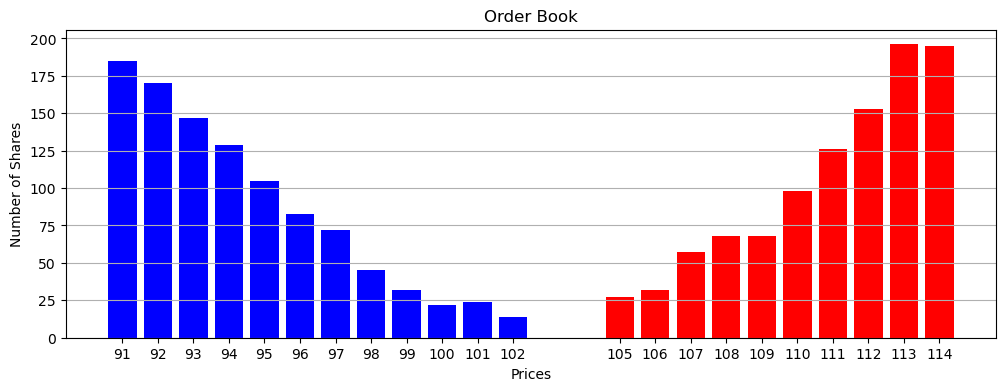

New trade: BUY MARKET order with size 20.


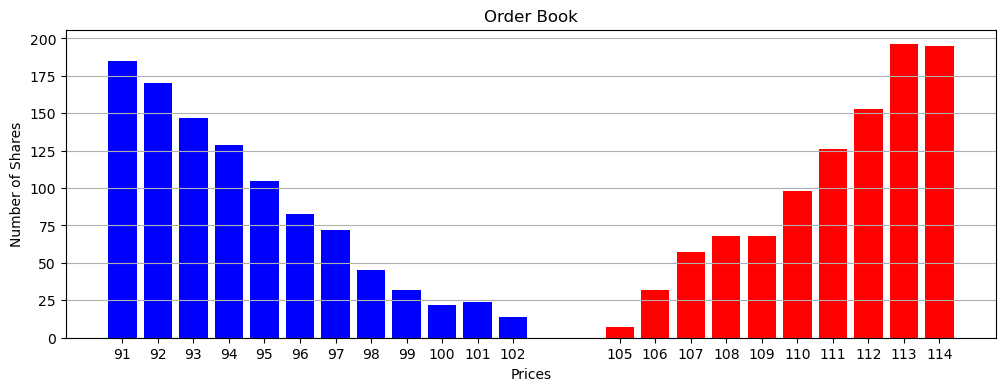

New trade: BUY LIMIT order with price 94 and size 11.


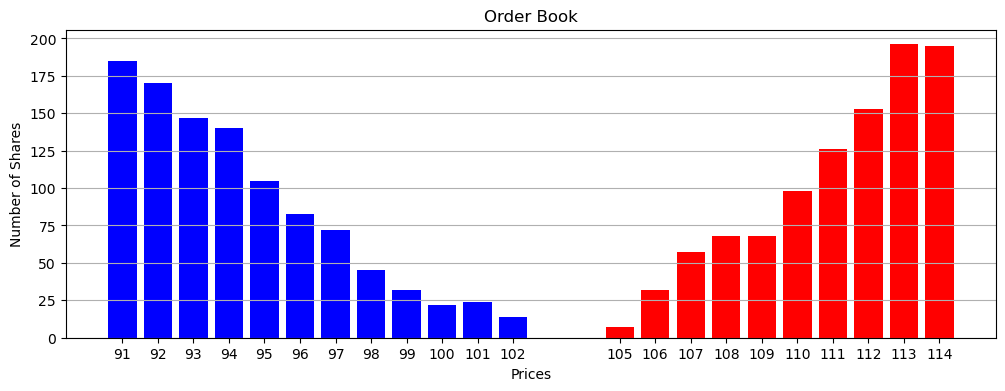

New trade: BUY MARKET order with size 16.


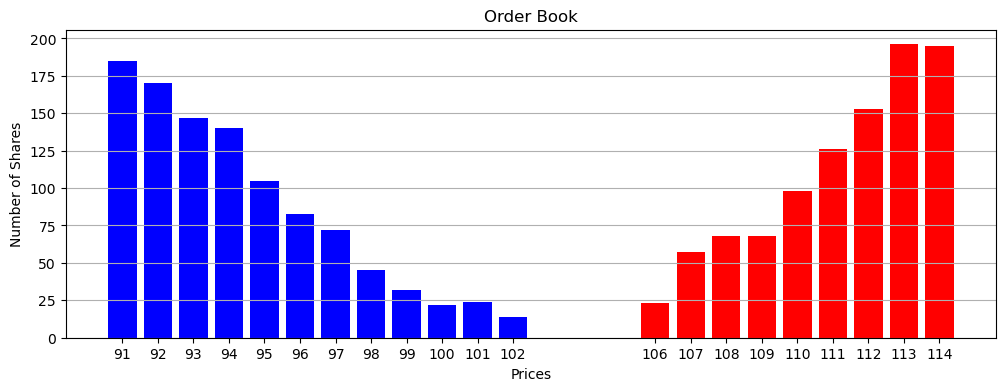

New trade: SELL LIMIT order with price 104 and size 17.


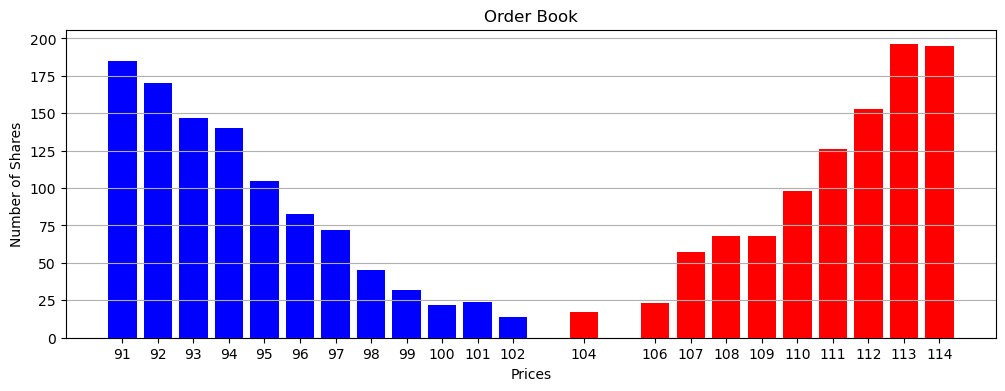

New trade: SELL MARKET order with size 11.


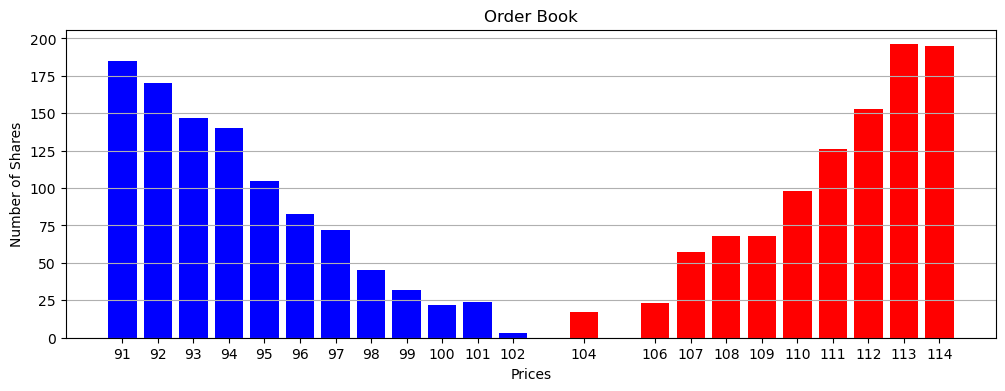

In [7]:
run_LOB(
    f_order_size = lambda lob: round(uniform(10, 20)),
    f_limit_price = lambda lob: round(uniform(lob.descending_bids[-1].dollars, lob.ascending_asks[-1].dollars))
)

## Question 4
Derive the expressions for the Optimal Value Function and Optimal Policy
for the *Linear-Percentage Temporary* (LPT) Price Impact Model
formulated by Bertsimas and Lo. The LPT model is described below for all
$t = 0, 1, \ldots T-1$:

$$P_{t+1} = P_t \cdot e^{Z_t}$$ 

$$X_{t+1} = \rho \cdot X_t + \eta_t$$

$$Q_t = P_t \cdot (1 - \beta \cdot N_t - \theta \cdot X_t)$$ 

where $Z_t$ are independent and identically distributed random variables with mean
$\mu_Z$ and variance $\sigma^2_Z$ for all $t = 0, 1, \ldots, T-1$,
$\eta_t$ are independent and identically distributed random variables
with mean 0 for all $t = 0, 1, \ldots, T-1$, $Z_t$ and $\eta_t$ are
independent of each other for all $t = 0, 1, \ldots, T-1$, and
$\rho, \beta, \theta$ are given constants. The model assumes no
risk-aversion (Utility function is the identity function) and so, the
objective is to maximize the Expected Total Sales Proceeds over the
finite-horizon up to time $T$ (discount factor is 1). In your
derivation, use the same methodology as we followed for the *Simple
Linear Price Impact Model with no Risk-Aversion*.

Implement this LPT model by customizing the class
`OptimalOrderExecution` in [rl/chapter9/optimal_order_execution.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter9/optimal_order_execution.py).

Compare the obtained Optimal Value Function and Optimal Policy against
the closed-form solution you derived above.

**Answer:**

$$V^\pi_t ((P_{t},R_{t}))=\mathbb E[\sum_{i=t}^TN_i(P_i(1-\beta\cdot N_i-\theta\cdot X_i))|(P_t,R_t)] $$

$$V^*_{t}((P_{t},R_{t}))=\max_{N_t}\{N_{t}\cdot(P_i(1-\beta\cdot N_t-\theta\cdot X_t))+\mathbb E[V^*_{t+1}((P_{t+1},R_{t+1}))]\}$$

$$V^*_{T-1}((P_{T-1},R_{T-1}))=N_{T-1}\cdot P_{T-1}(1-\beta\cdot N_{T-1}-\theta\cdot X_{T-1})=R_{T-1}\cdot P_{T-1}(1-\beta\cdot R_{T-1}-\theta\cdot X_{T-1})$$
$$V^*_{T-2}((P_{T-2},R_{T-2}))=\max_{N_{T-2}}\{N_{T-2}\cdot P_{T-2}(1-\beta\cdot N_{T-2}-\theta\cdot X_{T-2})+\mathbb E[R_{T-1}\cdot P_{T-1}(1-\beta\cdot R_{T-1}-\theta\cdot X_{T-1})]\}$$
$$V^*_{T-2}((P_{T-2},R_{T-2}))=\max_{N_{T-2}}\{N_{T-2}\cdot P_{T-2}(1-\beta\cdot N_{T-2}-\theta\cdot X_{T-2})+\mathbb E[(R_{T-2}-N_{T-2})\cdot P_{T-2} \cdot e^{Z_{T-2}}(1-\beta\cdot (R_{T-2}-N_{T-2})-\theta\cdot (\rho\cdot X_{T-2}+\eta_t))]\}$$
$$V^*_{T-2}((P_{T-2},R_{T-2}))=\max_{N_{T-2}}\{N_{T-2}\cdot P_{T-2}(1-\beta\cdot N_{T-2}-\theta\cdot X_{T-2})+(R_{T-2}-N_{T-2})\cdot P_{T-2} \cdot e^{\mu_Z+\frac12\sigma_Z^2}(1-\beta\cdot (R_{T-2}-N_{T-2})-\theta\cdot \rho\cdot X_{T-2})\}$$

Differenciating w.r.t $N_{T-2}$:
$$P_{T-2}(1-2\beta\cdot N_{T-2}-\theta\cdot X_{T-2})- P_{T-2} \cdot e^{\mu_Z+\frac12\sigma_Z^2}(1-2\beta\cdot (R_{T-2}-N_{T-2})-\theta\cdot \rho\cdot X_{T-2})=0$$

$$2\beta (1+e^{\mu_Z+\frac12\sigma_Z^2})\cdot N_{T-2}= 1-\theta\cdot X_{T-2}-e^{\mu_Z+\frac12\sigma_Z^2}(1-2\beta\cdot R_{T-2}-\theta\cdot \rho\cdot X_{T-2})$$
$$N^*_{T-2}= \frac{(1-e^{\mu_Z+\frac12\sigma_Z^2})(1-\theta\cdot X_{T-2})+2\beta\cdot e^{\mu_Z+\frac12\sigma_Z^2} R_{T-2}}{2\beta (1+e^{\mu_Z+\frac12\sigma_Z^2})} = c^{(1)}+c^{(2)}\cdot X_{T-2}+c^{(3)}\cdot R_{T-2}$$

Subsituting the optimal policy into the value function, we get:
$$V^*_{T-2}((P_{T-2},R_{T-2}))=( c^{(1)}+c^{(2)}\cdot X_{T-2}+c^{(3)}\cdot R_{T-2})\cdot P_{T-2}(1-\beta\cdot ( c^{(1)}+c^{(2)}\cdot X_{T-2}+c^{(3)}\cdot R_{T-2})-\theta\cdot X_{T-2})+(R_{T-2}-( c^{(1)}+c^{(2)}\cdot X_{T-2} +c^{(3)}\cdot R_{T-2}))\cdot P_{T-2} \cdot e^{\mu_Z+\frac12\sigma_Z^2}(1-\beta\cdot (R_{T-2}-( c^{(1)}+c^{(2)}\cdot X_{T-2}+c^{(3)}\cdot R_{T-2}))-\theta\cdot \rho\cdot X_{T-2})$$
$$V^*_{T-2}((P_{T-2},R_{T-2}))=P_{T-2}e^{\mu_Z+\frac12\sigma_Z^2}( c^{(4)}+c^{(5)}\cdot R_{T-2}+c^{(6)}\cdot X_{T-2}+c^{(7)}\cdot R^2_{T-2}+c^{(8)}\cdot X^2_{T-2}+c^{(9)}\cdot X_{T-2}\cdot R_{T-2})$$
Iteratibely we can get that for any time step $t$:
$$N^*_{t}=  c_t^{(1)}+c_t^{(2)}\cdot X_{t}+c_t^{(3)}\cdot R_{t}$$
$$V^*_{t}((P_{t},R_{t}))=P_{t}e^{\mu_Z+\frac12\sigma_Z^2}( c^{(4)}+c^{(5)}\cdot R_{t}+c^{(6)}\cdot X_{t}+c^{(7)}\cdot R^2_{t}+c^{(8)}\cdot X^2_{t}+c^{(9)}\cdot X_{t}\cdot R_{t})$$

In [41]:
@dataclass(frozen=True)
class PriceAndShares:
    price: float
    shares: int
    market_factor: float
    

@dataclass(frozen=True)
class OptimalOrderExecution:
    '''
    shares refers to the total number of shares N to be sold over
    T time steps.

    time_steps refers to the number of time steps T.

    avg_exec_price_diff refers to the time-sequenced functions g_t
    that gives the average reduction in the price obtained by the
    Market Order at time t due to eating into the Buy LOs. g_t is
    a function of PriceAndShares that represents the pair of Price P_t
    and MO size N_t. Sales Proceeds = N_t*(P_t - g_t(P_t, N_t)).

    price_dynamics refers to the time-sequenced functions f_t that
    represents the price dynamics: P_{t+1} ~ f_t(P_t, N_t). f_t
    outputs a distribution of prices.

    market_dynamics refers to the time-sequenced functions that
    represents the market dynamics.

    utility_func refers to the Utility of Sales proceeds function,
    incorporating any risk-aversion.

    discount_factor refers to the discount factor gamma.

    func_approx refers to the FunctionApprox required to approximate
    the Value Function for each time step.

    initial_price_distribution refers to the distribution of prices
    at time 0 (needed to generate the samples of states at each time step,
    needed in the approximate backward induction algorithm).

    initial_market_distribution refers to the distribution of the Serially-Correlated Variable
    at time 0 (needed to generate the samples of states at each time step,
    needed in the approximate backward induction algorithm).
    '''
    shares: int
    time_steps: int
    avg_exec_price_diff: Sequence[Callable[[PriceAndShares], float]]
    price_dynamics: Sequence[Callable[[PriceAndShares], Distribution[float]]]
    market_dynamics: Sequence[Callable[[PriceAndShares], Distribution[float]]]
    utility_func: Callable[[float], float]
    discount_factor: float
    func_approx: ValueFunctionApprox[PriceAndShares]
    initial_price_distribution: Distribution[float]
    initial_market_distribution: Distribution[float]

    def get_mdp(self, t: int) -> MarkovDecisionProcess[PriceAndShares, int]:
        """
        State is (Price P_t, Remaining Shares R_t; Serially-Correlated Variable X_t)
        Action is shares sold N_t
        """

        utility_f: Callable[[float], float] = self.utility_func
        sc_dynamics: Sequence[Callable[[PriceAndShares], float]] = \
            self.market_dynamics
        price_diff: Sequence[Callable[[PriceAndShares], float]] = \
            self.avg_exec_price_diff
        dynamics: Sequence[Callable[[PriceAndShares], Distribution[float]]] = \
            self.price_dynamics
        steps: int = self.time_steps

        class OptimalExecutionMDP(MarkovDecisionProcess[PriceAndShares, int]):

            def step(
                self,
                p_r: NonTerminal[PriceAndShares],
                sell: int
            ) -> SampledDistribution[Tuple[State[PriceAndShares],
                                           float]]:

                def sr_sampler_func(
                    p_r=p_r,
                    sell=sell
                ) -> Tuple[State[PriceAndShares], float]:
                    p_s: PriceAndShares = PriceAndShares(
                        price=p_r.state.price,
                        shares=sell,
                        market_factor=p_r.state.market_factor
                    )
                    next_market_factor: float = sc_dynamics[t](p_s).sample()
                    next_price: float = dynamics[t](p_s).sample()
                    next_rem: int = p_r.state.shares - sell
                    next_state: PriceAndShares = PriceAndShares(
                        price=next_price,
                        shares=next_rem,
                        market_factor=next_market_factor
                    )
                    reward: float = utility_f(
                        sell * (p_r.state.price - price_diff[t](p_s))
                    )
                    return (NonTerminal(next_state), reward)

                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=100
                )

            def actions(self, p_s: NonTerminal[PriceAndShares]) -> \
                    Iterator[int]:
                if t == steps - 1:
                    return iter([p_s.state.shares])
                else:
                    return iter(range(p_s.state.shares + 1))

        return OptimalExecutionMDP()

    def get_states_distribution(self, t: int) -> \
            SampledDistribution[NonTerminal[PriceAndShares]]:

        def states_sampler_func() -> NonTerminal[PriceAndShares]:
            price: float = self.initial_price_distribution.sample()
            rem: int = self.shares            
            market_factor = self.initial_market_distribution.sample()
            for i in range(t):
                sell: int = Choose(range(rem + 1)).sample()
                market_factor = self.market_dynamics[i](PriceAndShares(
                    price=price,
                    shares=rem,
                    market_factor=market_factor
                )).sample()
                price = self.price_dynamics[i](PriceAndShares(
                    price=price,
                    shares=rem,
                    market_factor=market_factor
                )).sample()
                rem -= sell
            return NonTerminal(PriceAndShares(
                price=price,
                shares=rem,
                market_factor=market_factor
            ))

        return SampledDistribution(states_sampler_func)

    def backward_induction_vf_and_pi(
        self
    ) -> Iterator[Tuple[ValueFunctionApprox[PriceAndShares],
                        DeterministicPolicy[PriceAndShares, int]]]:

        mdp_f0_mu_triples: Sequence[Tuple[
            MarkovDecisionProcess[PriceAndShares, int],
            ValueFunctionApprox[PriceAndShares],
            SampledDistribution[NonTerminal[PriceAndShares]]
        ]] = [(
            self.get_mdp(i),
            self.func_approx,
            self.get_states_distribution(i)
        ) for i in range(self.time_steps)]

        num_state_samples: int = 10000
        error_tolerance: float = 1e-6

        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=mdp_f0_mu_triples,
            γ=self.discount_factor,
            num_state_samples=num_state_samples,
            error_tolerance=error_tolerance
        )




In [43]:
class LogNormal(SampledDistribution[float]):
    '''A Log Normal distribution with the given μ, σ and C (constant)'''

    μ: float
    σ: float
    C: float

    def __init__(self, μ: float, σ: float, C: float, expectation_samples: int = 10000):
        self.μ = μ
        self.σ = σ
        self.C = C
        super().__init__(
            sampler=lambda: C*np.random.lognormal(mean=self.μ, sigma=self.σ),
            expectation_samples=expectation_samples
        )




num_shares: int = 100
num_time_steps: int = 10


eta_t_stdev: float = 0.1
z_mean: float = 0.0
z_stdev: float = 0.5

rho: float = 0.03
beta: float = 0.05
theta: float = 0.05


x_t = [lambda p_s: Gaussian(
    μ=rho*p_s.market_factor,
    σ=eta_t_stdev
) for _ in range(num_time_steps)]


price_diff = [lambda p_s:  p_s.price * (beta * p_s.shares+theta * p_s.market_factor) for _ in range(num_time_steps)]



price_dynamics = [lambda p_s: LogNormal(
    μ=z_mean, 
    σ=z_stdev,
    C = p_s.price
) for _ in range(num_time_steps)]

fa: FunctionApprox = LinearFunctionApprox.create(feature_functions=ffs)



init_price_mean: float = 100.0
init_price_stdev: float = 10.0
init_price_distrib: Gaussian = Gaussian(
    μ=init_price_mean,
    σ=init_price_stdev
)

init_market_mean: float = 1.0
init_market_stdev: float = 0.1
initial_market_distrib: Gaussian = Gaussian(
    μ=init_price_mean,
    σ=init_price_stdev
)


ooe: OptimalOrderExecution = OptimalOrderExecution(
        shares=num_shares,
        time_steps=num_time_steps,
        avg_exec_price_diff=price_diff,
        price_dynamics=price_dynamics,
        market_dynamics=x_t,
        utility_func=lambda x: x,
        discount_factor=1,
        func_approx=fa,
        initial_price_distribution=init_price_distrib,
        initial_market_distribution=initial_market_distrib
    )


it_vf: Iterator[Tuple[ValueFunctionApprox[PriceAndShares],
                      DeterministicPolicy[PriceAndShares, int]]] = \
    ooe.backward_induction_vf_and_pi()

state: PriceAndShares = PriceAndShares(
    price=init_price_mean,
    shares=num_shares,
    market_factor=init_market_mean
)
print("Backward Induction: VF And Policy")
print("---------------------------------")
print()
for t, (vf, pol) in enumerate(it_vf):
    print(f"Time {t:d}")
    print()
    opt_sale: int = pol.action_for(state)
    val: float = vf(NonTerminal(state))
    print(f"Optimal Sales = {opt_sale:d}, Opt Val = {val:.3f}")
    print()
    print("Optimal Weights below:")
    print(vf.weights.weights)
    print()


Backward Induction: VF And Policy
---------------------------------

Time 0

Optimal Sales = 9, Opt Val = 29662.902

Optimal Weights below:
[ 3.19194943 -0.22565919]

Time 1

Optimal Sales = 5, Opt Val = 25049.167

Optimal Weights below:
[ 2.74188502 -0.23696831]

Time 2

Optimal Sales = 0, Opt Val = 20450.323

Optimal Weights below:
[ 2.31904234 -0.27401004]

Time 3

Optimal Sales = 3, Opt Val = 16314.426

Optimal Weights below:
[ 1.97105265 -0.33961003]

Time 4

Optimal Sales = 1, Opt Val = 12348.132

Optimal Weights below:
[ 1.68444748 -0.44963424]

Time 5

Optimal Sales = 4, Opt Val = 8559.641

Optimal Weights below:
[ 1.44326226 -0.58729812]

Time 6

Optimal Sales = 0, Opt Val = 4402.615

Optimal Weights below:
[ 1.2398302  -0.79956872]

Time 7

Optimal Sales = 4, Opt Val = -2619.778

Optimal Weights below:
[ 1.07953206 -1.34150982]

Time 8

Optimal Sales = 2, Opt Val = -11457.245

Optimal Weights below:
[ 0.92254118 -2.06826566]

Time 9

Optimal Sales = 3, Opt Val = -46603.408

O